<a href="https://colab.research.google.com/github/paulrobustelli/CHEM101.6/blob/main/Butane_OpenMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CHEM 101.6 Project1

This is a Jupyter notebook for running and analyzing a Molecular Dynamics (MD) simulations of Butane using the OpenMM engine 

---
---
# **Setting the environment for MD calculation**

Firstly, we need to install all necessary libraries and packages for our simulation. The main packages we will be installing are:

1.    OpenMM (https://openmm.org/)
2.    PyTraj (https://amber-md.github.io/pytraj/latest/index.html)
3.    py3Dmol (https://pypi.org/project/py3Dmol/)
4.    Numpy (https://numpy.org/)
5.    Matplotlib (https://matplotlib.org/)
8.    AmberTools (https://ambermd.org/AmberTools.php)

Load libraries in conda enviroment:

conda install -c conda-forge openmm 

conda install -y -q -c conda-forge openmm=7.6 python=3.7 pdbfixer

conda install -c conda-forge ambertools

conda install -c ambermd pytraj 

conda install -c conda-forge biopandas

conda install -c conda-forge mdanalysis

conda install -c conda-forge py3dmol

conda install -c conda-forge jupyterlab

conda install -c conda-forge mdtraj

conda install -c conda-forge nglview



In [1]:
import numpy as np
import py3Dmol
import platform
import scipy.cluster.hierarchy

from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#load dependencies

import os
import sys
from simtk import openmm as mm

import openmm as mm
from openmm import *
from openmm import unit
from openmm import app


import numpy as np
import py3Dmol

#import pytraj as pt
import platform
import scipy.cluster.hierarchy

from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

from scipy.interpolate import griddata
from scipy.optimize import curve_fit
import seaborn as sb
from statistics import mean, stdev
#from pytraj import matrix
from matplotlib import colors
from IPython.display import set_matplotlib_formats

import MDAnalysis as mda
import mdtraj as md
import seaborn as sns


In [3]:
from __future__ import print_function
from IPython.display import set_matplotlib_formats


In [4]:
datadir='/Users/paulrobustelli/Desktop/CHEM.101.6/butane/data/'
workDir='/Users/paulrobustelli/Desktop/CHEM.101.6/butane/outdir/'
initial_pdb='/Users/paulrobustelli/Desktop/CHEM.101.6/butane/data/butane.pdb'
force_field='/Users/paulrobustelli/Desktop/CHEM.101.6/butane/data/butane.gaff2.xml'

if not os.path.exists(workDir):
    os.makedirs(workDir)
    
print(initial_pdb)
print(force_field )

pdb = mm.app.PDBFile(initial_pdb)
forcefield = mm.app.ForceField(force_field)


system = forcefield.createSystem(pdb.topology, nonbondedMethod=mm.app.NoCutoff, constraints=mm.app.HBonds)
integrator = mm.LangevinIntegrator(298.15*unit.kelvin, 5.0/unit.picoseconds, 2.0*unit.femtoseconds)
integrator.setConstraintTolerance(1e-5)

platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

/Users/paulrobustelli/Desktop/CHEM.101.6/butane/data/butane.pdb
/Users/paulrobustelli/Desktop/CHEM.101.6/butane/data/butane.gaff2.xml


In [5]:
integrator = mm.LangevinIntegrator(298.15*unit.kelvin, 5.0/unit.picoseconds, 2.0*unit.femtoseconds)
integrator.setConstraintTolerance(1e-5)

print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 5.797528692127868 kJ/mol
Potential energy after minimization is 5.295784483017486 kJ/mol


In [6]:
from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 100, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*unit.kelvin)
simulation.step(2500)

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
100,19.037452819276208,153.46786751598634
200,54.85505547801439,261.5775880926315
300,25.774284101557505,164.64799044682493
400,38.78993970017678,164.6485912985846
500,53.959427656602834,281.2048432306074
600,55.295378737227566,272.4964146321246
700,30.520119018936768,414.29477201479006
800,43.76126987750322,269.2974338581033
900,43.21570022620863,311.3642757815861
1000,43.202642066984446,383.93544865967453
1100,27.83669399768337,279.4051598882763
1200,41.610256708208425,182.5919703500597
1300,52.682215339595736,414.43142439825135
1400,55.42871427560702,385.6055393381601
1500,28.725233531516547,275.73589666500783
1600,44.511494213911256,254.9012177738933
1700,31.41242635682535,247.5111117258046
1800,43.31322862708145,272.99588855721447
1900,52.116428396737646,236.34382649832435
2000,48.37556754269123,208.12536396265622
2100,43.870953135324896,424.8071982072531
2200,56.79800299883216,333.22052450778784
2300,27.24298

In [7]:
import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.DCDReporter(workDir+'butane_sim.dcd', 100))

# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(1000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
250000,500.0000000016593,39.50024399450833,403.99830720640114,0
500000,999.9999999901769,44.70025236681495,393.91115682504125,1.8e+04
750000,1499.9999999783536,31.69185245359066,214.96017751349942,1.83e+04
1000000,1999.9999999665301,40.67487345754039,270.3376371646119,1.83e+04
Done!
Time required for simulation: 9.520987272262573 seconds


In [8]:
#print(workDir+'butane_sim.dcd')
#simulation.reporters.append(app.DCDReporter(workDir+'butane_sim.dcd', 100))
traj = md.load(workDir+'butane_sim.dcd', top=initial_pdb)
traj
#traj.superpose(ref)

<mdtraj.Trajectory with 10000 frames, 14 atoms, 1 residues, without unitcells at 0x7f87d7605340>

In [9]:
#jupyter-nbextension enable --py --user nglview
#jupyter-nbextension enable --py --user widgetsnbextension 

import ipywidgets
from ipywidgets import interact, fixed
import warnings
import nglview as ngl
from nglview.player import TrajectoryPlayer
traj = md.load(workDir+'butane_sim.dcd', top=initial_pdb)
t = ngl.MDTrajTrajectory(traj)
w = ngl.NGLWidget(t)
w

NGLWidget(max_frame=9999)

In [10]:
atoms, bonds = traj.topology.to_dataframe()
atoms

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,C1,C,1,NBU,0,
1,2,H11,H,1,NBU,0,
2,3,H12,H,1,NBU,0,
3,4,H13,H,1,NBU,0,
4,5,C2,C,1,NBU,0,
5,6,H21,H,1,NBU,0,
6,7,H22,H,1,NBU,0,
7,8,C3,C,1,NBU,0,
8,9,H31,H,1,NBU,0,
9,10,H32,H,1,NBU,0,


In [11]:
#Lets select the topology
top=traj.topology
top

<mdtraj.Topology with 1 chains, 1 residues, 14 atoms, 13 bonds at 0x7f87d82bfa30>

In [12]:
#Select All Carbon Atoms
C_sel=top.select("type C")
print(C_sel)
#Confirm that we have selected what we think we have
for atom in C_sel:
    print(top.atom(atom))

[ 0  4  7 10]
NBU1-C1
NBU1-C2
NBU1-C3
NBU1-C4


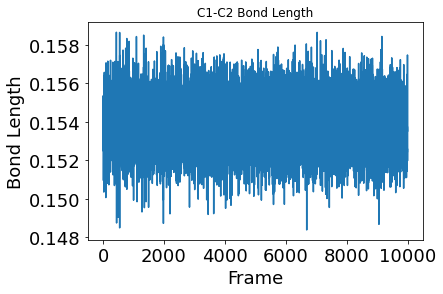

In [13]:
#Compute Some Distances and plot the time course
bond_indices = [0, 4] 
C1C2bondlength = md.compute_distances(traj, [bond_indices])
plt.plot(C1C2bondlength)
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C1-C2 Bond Length')
plt.show()

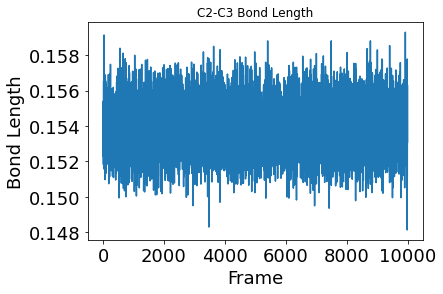

In [14]:
bond_indices = [4, 7] 
C2C3bondlength = md.compute_distances(traj, [bond_indices])
plt.plot(C2C3bondlength)
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C2-C3 Bond Length')
plt.show()

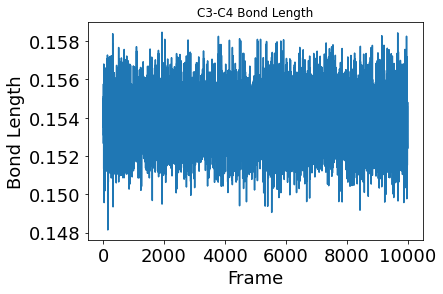

In [15]:
bond_indices = [7, 10] 
C3C4bondlength = md.compute_distances(traj, [bond_indices])
plt.plot(C3C4bondlength)
plt.xlabel('Frame', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C3-C4 Bond Length')
plt.show()

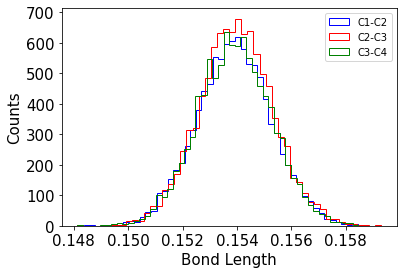

In [16]:
#https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
plt.hist(C1C2bondlength,label='C1-C2',color='b',histtype='step',bins=50)
plt.hist(C2C3bondlength,label='C2-C3',color='r',histtype='step',bins=50)
plt.hist(C3C4bondlength,label='C3-C4',color='g',histtype='step',bins=50)
plt.legend(loc='upper right')
plt.xlabel('Bond Length', size=15)
plt.xticks(size=15)
plt.ylabel('Counts', size=15)
plt.yticks(size=15)
plt.show()

Lets Write Functions to Calculate the Variance ($\sigma^2$) and Standard Deviation ($\sigma$)

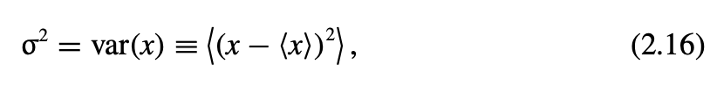

In [17]:
######Class Activtiy: Calculate the Variance and Standard Deviation of Each Bond Length######


In [18]:
###SOLUTION###
def variance(data):
    ave=np.average(data)
    var= np.average((data-ave)**2)
    std=var**0.5
    return var,std

C1C2var,C1C2std=variance(C1C2bondlength)
C2C3var,C2C3std=variance(C2C3bondlength)
C3C4var,C3C4std=variance(C3C4bondlength)
print("C1-C2 var:",C1C2var,"C2-C3 var:",C2C3var,"C3-C4 var:",C3C4var)
print("C1-C2 std:",C1C2std,"C2-C3 std:",C2C3std,"C3-C4 std:",C3C4std)

C1-C2 var: 1.8904909e-06 C2-C3 var: 1.835293e-06 C3-C4 var: 1.8436266e-06
C1-C2 std: 0.0013749512431869952 C2-C3 std: 0.0013547298644267934 C3-C4 std: 0.001357802118069988


In [19]:
#Lets Check Our Answers with the Built In Numpy Libraries
print("C1-C2 average:",np.average(C1C2bondlength),"variance:",np.var(C1C2bondlength),"std-dev:",np.std(C1C2bondlength))
print("C2-C3 average:",np.average(C2C3bondlength),"variance:",np.var(C2C3bondlength),"std-dev:",np.std(C2C3bondlength))
print("C3-C4 average:",np.average(C3C4bondlength),"variance:",np.var(C3C4bondlength),"std-dev:",np.std(C3C4bondlength))

C1-C2 average: 0.15388276 variance: 1.8904909e-06 std-dev: 0.0013749512
C2-C3 average: 0.1539548 variance: 1.835293e-06 std-dev: 0.0013547299
C3-C4 average: 0.1539066 variance: 1.8436266e-06 std-dev: 0.0013578021


***Class Activity: Lets Check if These Bond Lengths Are Correlated and Calculate the Coerrleation Coefficents***

***First Calculate a Best Fit Line****

We can do this using the np.polyfit function:

https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html

***Now Calculate the Perason Correlation Coefficient***
We can use numpy to calculate the correlation coeffient 

https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html

This function works for n-arrays, so it will report correlation coefficient matrix, and we need to select our coefficient of interest, which in our case is the off diagnol  


Line Parameters: [-0.10364214  0.16990355]


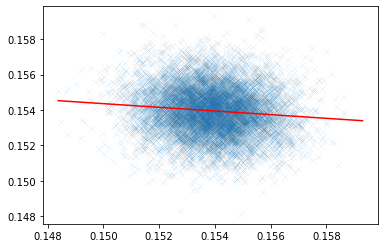

r2: -0.10518915387880212
Line Parameters: [0.00330767 0.1533976 ]


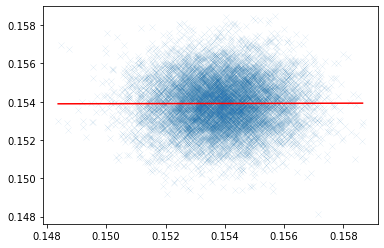

r2: 0.003349445106186572


In [20]:
#####Are these bond lengths correlated?##### 
###Calculate and plot a best fit line, and calculate the correlation coefficient####

plt.scatter(C1C2bondlength,C2C3bondlength,marker='x',linewidth=0.05)

#######SOLUTION###########


line_fit=np.polyfit(C1C2bondlength[:,0],C2C3bondlength[:,0],1)
x = np.linspace(min(C1C2bondlength[:,0]), max(C2C3bondlength[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.show()
plt.clf()

r=np.corrcoef(C1C2bondlength[:,0], C2C3bondlength[:,0])
print("r2:",r[0,1])

plt.scatter(C1C2bondlength,C3C4bondlength,marker='x',linewidth=0.05)

line_fit=np.polyfit(C1C2bondlength[:,0],C3C4bondlength[:,0],1)
x = np.linspace(min(C1C2bondlength[:,0]), max(C1C2bondlength[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.show()

r=np.corrcoef(C1C2bondlength[:,0], C3C4bondlength[:,0])
print("r2:",r[0,1])

**Homework Question:  Why does one pair of these bonds appear more correlated than the other?**

***Class Activity*** 

Lets Turn these histograms into a probability densities and then fit them to a
normal (Gaussian) Distribution

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

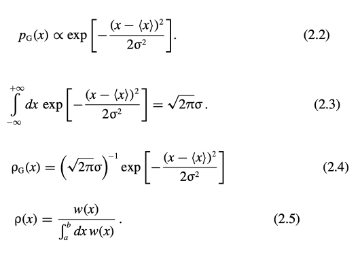
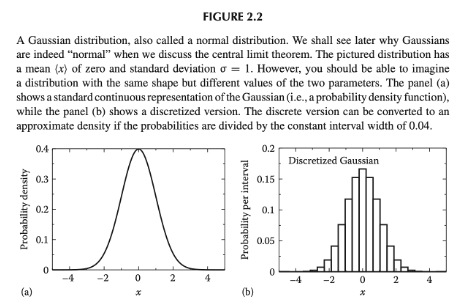

a: 0.188874948232402 x0: 0.15388405422722198 fit_sigma: -0.0013663632260182523


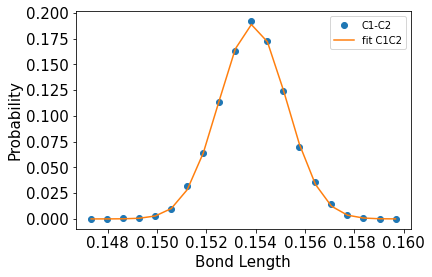

In [21]:
#Lets calculate a Probability Density and fit a gaussian to these
#First lets pull out the data in a formate we can fit
#https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

from scipy.optimize import curve_fit



#First we convery our histogram into bin centers and probabilities
#isntead of bin edges and counts:


def histogram_bincenters(a,x0,xmax,bins):
    counts, edges = np.histogram(a, bins=bins, range=[x0, xmax])
    centers = edges[:-1] + np.diff(edges)/2
    density=counts/np.sum(counts)
    return density, centers


###Now we define a gaussian function that we'll fit to our probability densities

def gauss(x, a, x0, sigma):
    return (a*np.exp(-(x-x0)**2/(2*sigma**2)))

#### Now we define a function to fit the gaussian with curve fit

def fit_gauss(x,y):
    parameters, covariance = curve_fit(gauss, x, y)
    fit_a = parameters[0]
    fit_x0 = parameters[1]
    fit_sigma = parameters[2]
    print("a:",fit_a,"x0:",fit_x0,"fit_sigma:",fit_sigma)
    fit_y = gauss(centers, fit_a, fit_x0,fit_sigma)
    return fit_y,[fit_a,fit_x0,fit_sigma] 

C1C2_density,centers=histogram_bincenters(C1C2bondlength,0.147,0.160,20)
C1C2_fit,C1C2_fit_params=fit_gauss(centers,C1C2_density)

plt.plot(centers, C1C2_density, 'o', label='C1-C2')
plt.plot(centers, C1C2_fit, '-', label='fit C1C2')


plt.legend()
plt.xlabel('Bond Length', size=15)
plt.xticks(size=15)
plt.ylabel('Probability', size=15)
plt.yticks(size=15)
plt.show()


In [22]:
output_directory='/Users/paulrobustelli/Desktop'
np.savetxt(output_directory+'test.dat',C1C2bondlength)

In [23]:
output_directory='/Users/paulrobustelli/Desktop'
a=np.loadtxt(output_directory+'test.dat')
a

array([0.15263069, 0.15440191, 0.15319036, ..., 0.15746704, 0.15196632,
       0.15256017])

***Homework Porblem 1:  Can you write a function to calculate the histogram, return the density and centers
and fit a guassian to each of these distributions?***

a: 0.188874948232402 x0: 0.15388405422722198 fit_sigma: -0.0013663632260182523
a: 0.19207854979237304 x0: 0.153945065491681 fit_sigma: -0.0013418831678202133
a: 0.18941036639299952 x0: 0.15390742890030626 fit_sigma: -0.0013686949448031582


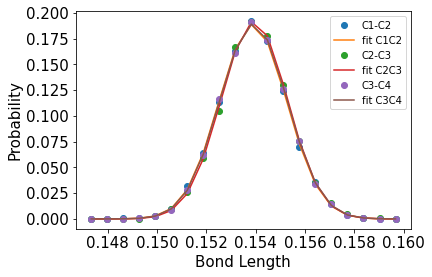

In [24]:
#Can you write a function to calculate the histogram, return the density and centers,
#and then fit a guassian to each of these distributions? 

####SOLUTION####

def histogram_bincenters(a,x0,xmax,bins):
    counts, edges = np.histogram(a, bins=bins, range=[x0, xmax])
    centers = edges[:-1] + np.diff(edges)/2
    density=counts/np.sum(counts)
    return density, centers

def gauss(x, a, x0, sigma):
    return (a*np.exp(-(x-x0)**2/(2*sigma**2)))

def fit_gauss(x,y):
    parameters, covariance = curve_fit(gauss, x, y)
    fit_a = parameters[0]
    fit_x0 = parameters[1]
    fit_sigma = parameters[2]
    print("a:",fit_a,"x0:",fit_x0,"fit_sigma:",fit_sigma)
    fit_y = gauss(centers, fit_a, fit_x0,fit_sigma)
    return fit_y,[fit_a,fit_x0,fit_sigma] 

C1C2_density,centers=histogram_bincenters(C1C2bondlength,0.147,0.160,20)
C1C2_fit,C1C2_fit_params=fit_gauss(centers,C1C2_density)

C2C3_density,centers=histogram_bincenters(C2C3bondlength,0.147,0.160,20)
C2C3_fit,C2C3_fit_params=fit_gauss(centers,C2C3_density)

C3C4_density,centers=histogram_bincenters(C3C4bondlength,0.147,0.160,20)
C3C4_fit,C3C4_fit_params=fit_gauss(centers,C3C4_density)


plt.plot(centers, C1C2_density, 'o', label='C1-C2')
plt.plot(centers, C1C2_fit, '-', label='fit C1C2')
plt.plot(centers, C2C3_density, 'o', label='C2-C3')
plt.plot(centers, C2C3_fit, '-', label='fit C2C3')
plt.plot(centers, C3C4_density, 'o', label='C3-C4')
plt.plot(centers, C3C4_fit, '-', label='fit C3C4')

plt.legend()
plt.xlabel('Bond Length', size=15)
plt.xticks(size=15)
plt.ylabel('Probability', size=15)
plt.yticks(size=15)
plt.show()


**Homework Problem #2: convert these probability distributions to culmulative distribution functions**

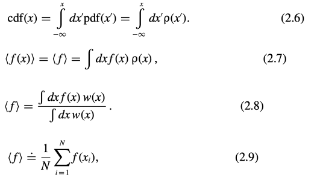

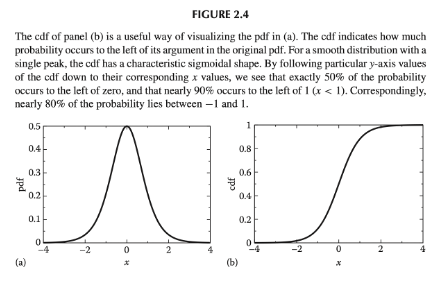

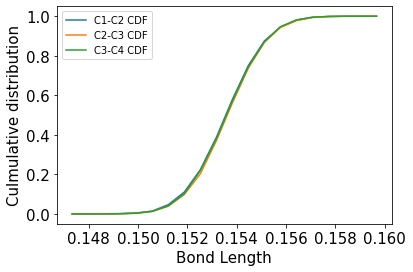

In [25]:
C1C2_total = []
C2C3_total = []
C3C4_total = []

y = 0
for i in C1C2_density:
    y += i
    C1C2_total.append(y)
y = 0
for i in C2C3_density:
    y += i
    C2C3_total.append(y)
y = 0
for i in C3C4_density:
    y += i
    C3C4_total.append(y)

plt.plot(centers,C1C2_total, '-', label = 'C1-C2 CDF')
plt.plot(centers,C2C3_total, '-', label = 'C2-C3 CDF')
plt.plot(centers,C3C4_total, '-', label = 'C3-C4 CDF')

plt.legend()
plt.xlabel('Bond Length', size=15)
plt.xticks(size=15)
plt.ylabel('Culmulative distribution', size=15)
plt.yticks(size=15)
plt.show()

**Homework Problem #3: Lets draw some different some random frames from our trajectory (for example 10,100, and 1000),  calculate the probability distribution functions for 5 of these random samples, and fit  gaussians to these probability distirbution functions***
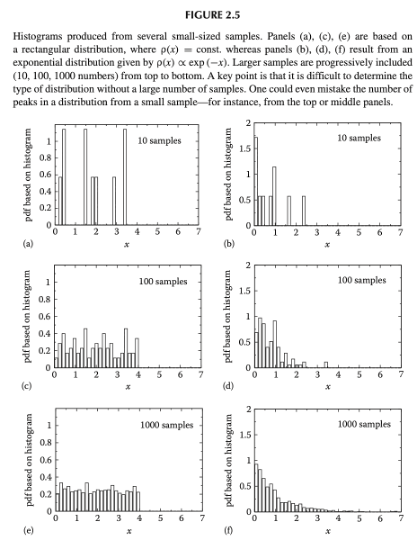

In [26]:
#HW PROBLEM 4: ADD CODE FOR CDFs HERE#

Frame number selected: 10
a: 0.29439707423074 x0: 0.15533329495356543 fit_sigma: 0.000621572620785431
a: 0.9783789458962484 x0: 1.3595551675368647 fit_sigma: 0.1592328495291594
a: 0.19908236257652626 x0: 0.15388213461385092 fit_sigma: -0.0013899354802139492


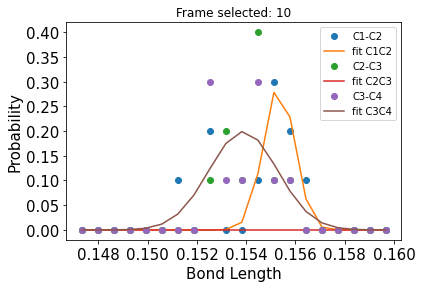

Frame number selected: 50
a: 0.22073568077238503 x0: 0.15423116404703027 fit_sigma: -0.0012054383833501093
a: -2.785423449006159 x0: -7.110939150053243 fit_sigma: -0.6692691841491697
a: 0.17704909383203393 x0: 0.1539668839769584 fit_sigma: -0.0014230896938255883


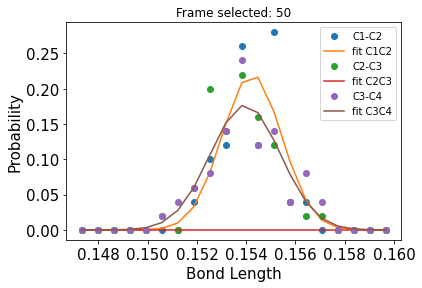

Frame number selected: 100
a: 0.16821843343275925 x0: 0.15390152465839255 fit_sigma: 0.001532891271413613
a: -3.908365845760689 x0: -6.786627541881154 fit_sigma: 0.5906811166899839
a: 0.1832557141796288 x0: 0.1540684257863774 fit_sigma: -0.0014432849644903333


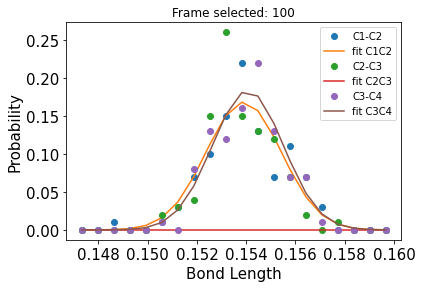

Frame number selected: 1000
a: 0.19109853107574407 x0: 0.15392843506357246 fit_sigma: -0.0013549673109537921
a: 0.19027012455922696 x0: 0.15397301271078614 fit_sigma: 0.001377567325964421
a: 0.1843133851915703 x0: 0.15383025622491378 fit_sigma: 0.0014140488888482446


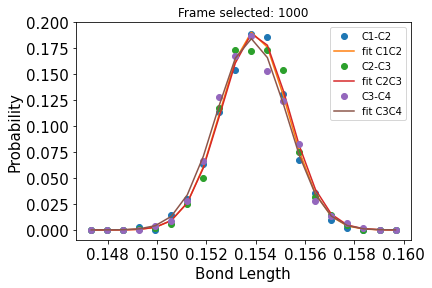

Frame number selected: 5000
a: 0.18523666977183934 x0: 0.15391073648741838 fit_sigma: -0.00139543407132863
a: 0.19245194034822832 x0: 0.15393684158035117 fit_sigma: -0.0013471758610991166
a: 0.19103614291152407 x0: 0.1538806817217236 fit_sigma: 0.0013626481250980347


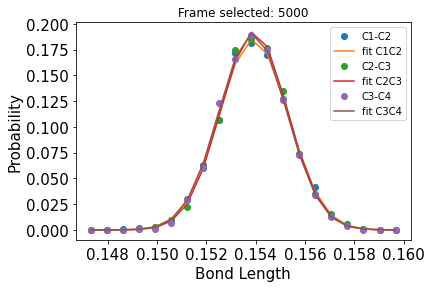

<Figure size 432x288 with 0 Axes>

In [27]:
#Draw 10,100,1000 random samples of a bond angle,

#This function might be helpful:
rands=np.random.randint(10000, size=(10))
rands

#ADD CODE FOR Random Samples here#
#Draw 10,100,1000 random samples of a bond angle,

#This function might be helpful:
frame_length = [10,50,100,1000,5000]
for i in frame_length:
    rands=np.random.randint(10000, size=(i))
    print('Frame number selected: ' + str(i))
    C1C2_short = C1C2bondlength[rands]
    C2C3_short = C2C3bondlength[rands]
    C3C4_short = C3C4bondlength[rands]
    C1C2_short_density, centers = histogram_bincenters(C1C2_short, 0.147, 0.160, 20)
    C1C2_short_fit, C1C2_short_fit_params = fit_gauss(centers,C1C2_short_density)

    C2C3_short_density, centers = histogram_bincenters(C2C3_short, 0.147, 0.160, 20)
    C2C3_short_fit, C2C3_short_fit_params = fit_gauss(centers,C2C3_short_density)

    C3C4_short_density, centers = histogram_bincenters(C3C4_short, 0.147, 0.160, 20)
    C3C4_short_fit, C3C4_short_fit_params = fit_gauss(centers,C3C4_short_density)

    plt.plot(centers,C1C2_short_density, 'o', label = 'C1-C2')
    plt.plot(centers, C1C2_short_fit, '-', label='fit C1C2')
    plt.plot(centers,C2C3_short_density, 'o', label = 'C2-C3')
    plt.plot(centers, C2C3_short_fit, '-', label='fit C2C3')
    plt.plot(centers,C3C4_short_density, 'o', label = 'C3-C4')
    plt.plot(centers, C3C4_short_fit, '-', label='fit C3C4')

    plt.legend()
    plt.title('Frame selected: ' + str(i))
    plt.xlabel('Bond Length', size=15)
    plt.xticks(size=15)
    plt.ylabel('Probability', size=15)
    plt.yticks(size=15)
    plt.show()
    plt.clf()

**Class Activity: Lets Compute the 2 C-C-C Bond Anlges and C-C-C-C Dihedral Angle ***

Plot their time course and their histograms.  Find a good way to visualize the C-C-C-C dihedral angle 

(10000, 2)


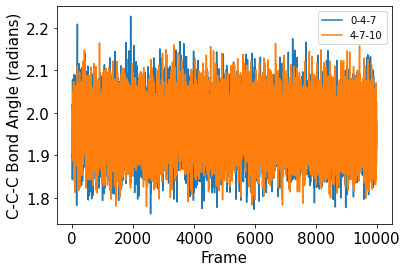

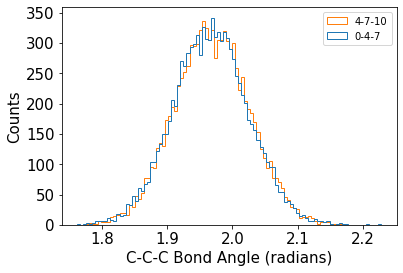

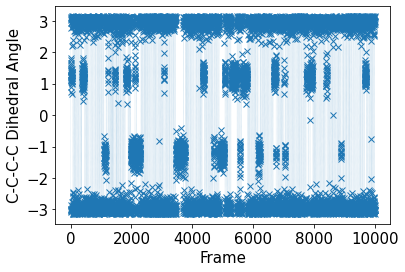

In [28]:
#Lets Compute Some Bond Angles 
Angle1=[0,4,7]
Angle2=[4,7,10]

ang = md.compute_angles(traj,[Angle1,Angle2])
#ang=np.degrees(angle_rad)
print(np.shape(ang))
plt.plot(ang,label=['0-4-7','4-7-10'])
plt.legend()
plt.xlabel('Frame', size=15)
plt.xticks(size=15)
plt.ylabel('C-C-C Bond Angle (radians)', size=15)
plt.yticks(size=15)
plt.show()

plt.show()
plt.clf()
plt.hist(ang,bins=100,histtype='step',label=['0-4-7','4-7-10'])
plt.legend()
plt.xlabel('C-C-C Bond Angle (radians)', size=15)
plt.xticks(size=15)
plt.ylabel('Counts', size=15)
plt.yticks(size=15)
plt.show()
plt.clf()

CCCC_index=[10,7,4,0]
CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])

#plt.plot(CCCC_torsion)
plt.plot(CCCC_torsion,marker='x',linewidth=.01)
#plt.xlim(0,2000)
plt.xlabel('Frame', size=15)
plt.xticks(size=15)
plt.ylabel('C-C-C-C Dihedral Angle', size=15)
plt.yticks(size=15)
plt.show()



***Homework Challenge Question:  Can you estimate the lifetime of the higher energy C-C-C-C dihedral states?*****

Gauche Transitions: 35 Average Residence Time (ps): 22971.428571428572


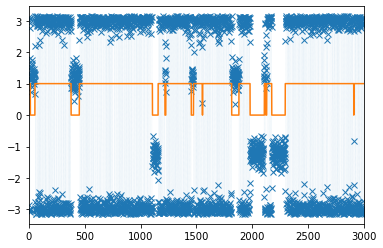

In [29]:
time_series=CCCC_torsion[:,0]
state_assign=np.zeros(len(time_series))
frame_set=np.where((CCCC_torsion[:,0]<-2) | (CCCC_torsion[:,0]>2))
state_assign[frame_set]=1
plt.plot(time_series,marker='x',linewidth=.01)
plt.plot(state_assign)
plt.xlim(0,3000)

gauche=0
n=0
res_time=[]

for i in range(1,len(state_assign)):
    if state_assign[i]==1:
     if gauche==0:
      gauche=1
     n+=1
    if state_assign[i]==0:
     gauche=0   
     if state_assign[i-1]!=0:
      res_time.append(n)
      n=0
#Traj=1000000 ps / 10000 frames
#100ps/frame
print("Gauche Transitions:",len(res_time),"Average Residence Time (ps):",np.average(res_time)*100)

**Class Activity: Are The Bond Angles and Dihedral Angle Correlated?**

r2: 0.0012715989577934772
[2.69477980e-05 1.96640127e+00]


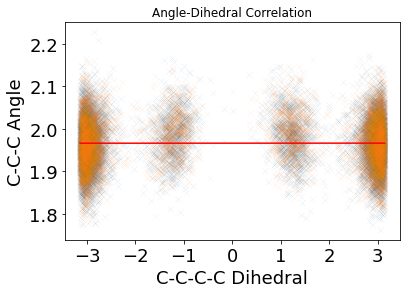

In [30]:
#Are the bond angle and dihedral correlated?

ang1=ang[:,0]
ang2=ang[:,1]

plt.scatter(CCCC_torsion,ang1,marker='x',linewidth=0.04)
plt.scatter(CCCC_torsion,ang2,marker='x',linewidth=0.04)

r=np.corrcoef(CCCC_torsion[:,0], ang1)
print("r2:",r[0,1])
line_fit=np.polyfit(CCCC_torsion[:,0],ang1,1)
x = np.linspace(min(CCCC_torsion[:,0]), max(CCCC_torsion[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print(line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel('C-C-C-C Dihedral', size=18)
plt.ylabel('C-C-C Angle', size=18)
plt.title('Angle-Dihedral Correlation')

plt.show()


#plt.scatter(ang1[1:-1:10],ang2[1:-1:10])
#r=np.corrcoef(ang1, ang2)
#print("Angle Correlation r^2:",r[0,1])


**Homework Problem 3: Can you express the relationsip between these two quantites using histograms and conditional probabilities ?** 

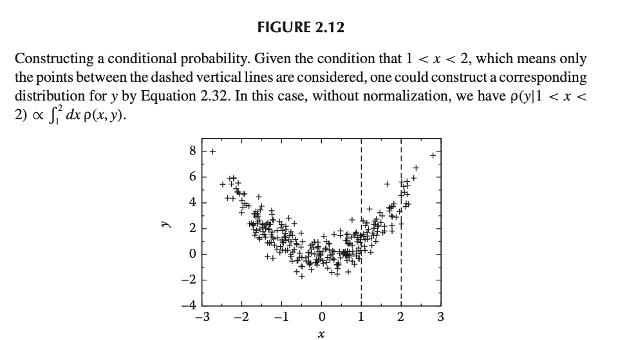

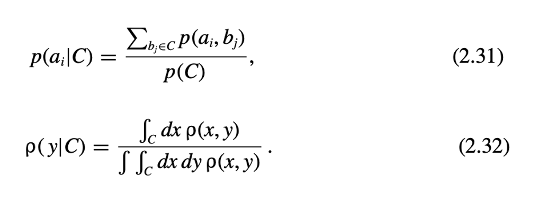

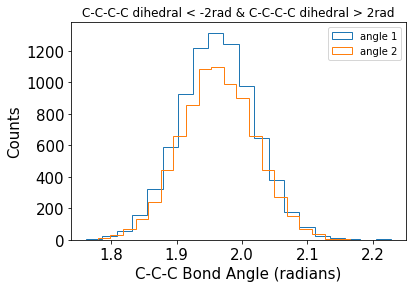

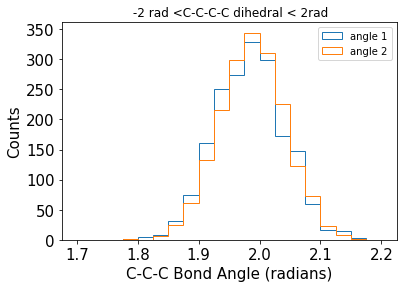

In [31]:
#Homework problem 3##
#One approach os to take a slice of the dihedral space, and plot the histogram/pdf for bond angles 

#Slice the dihedral angle to get all frames in a given interval

frame_set=np.where((CCCC_torsion[:,0]<-2) | (CCCC_torsion[:,0]>2))

plt.hist(ang1[frame_set],histtype='step',label='angle 1',bins=20)
plt.hist(ang2[frame_set],histtype='step',label='angle 2',bins=20)
plt.legend()
plt.title('C-C-C-C dihedral < -2rad & C-C-C-C dihedral > 2rad')
plt.xlabel('C-C-C Bond Angle (radians)', size=15)
plt.xticks(size=15)
plt.ylabel('Counts', size=15)
plt.yticks(size=15)

plt.show()
plt.clf()

frame_set=np.where((CCCC_torsion[:,0]>-2) & (CCCC_torsion[:,0]<2))
plt.title(' -2 rad <C-C-C-C dihedral < 2rad')

plt.hist(ang1[frame_set],histtype='step',label='angle 1',bins=20,range=[1.7,2.2])
plt.hist(ang2[frame_set],histtype='step',label='angle 2',bins=20,range=[1.7,2.2])
plt.legend()
plt.xlabel('C-C-C Bond Angle (radians)', size=15)
plt.xticks(size=15)
plt.ylabel('Counts', size=15)
plt.yticks(size=15)
plt.show()


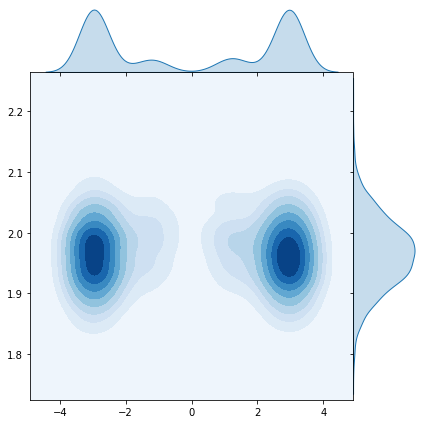

<Figure size 432x288 with 0 Axes>

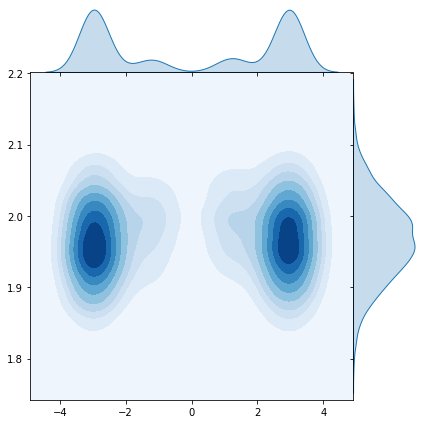

In [32]:
#Homework problem 3##

#Jiaqi's Solution sessential does this over all dihedral intervales with a nice 2D histogram
#https://github.com/jiaqizhu-git/-CHEM101.6/blob/main/Chem101.6_Project1_Students.ipynb

# 2d Histagram of C1-C2-C3-C4 dihedral and C1-C2-C3 angle
import seaborn as sns

sns.jointplot(x=CCCC_torsion[:,0],y=ang1,kind = 'kde', space=0, fill=True, thresh=0, cmap='Blues')
plt.show()

plt.clf()
# 2d Histagram of C1-C2-C3-C4 dihedral and C2-C3-C4 angle
sns.jointplot(x=CCCC_torsion[:,0],y=ang2,kind = 'kde', space=0, fill=True, thresh=0, cmap='Blues')
plt.show()

**Class Activity: Lets Calculate the Autocorrelation Times of C-C Bonds, C-C-C Angles, and C-C-C-C Dihedrals**

[0.00000000e+00 2.00020002e+00 4.00040004e+00 ... 1.99959996e+04
 1.99979998e+04 2.00000000e+04]


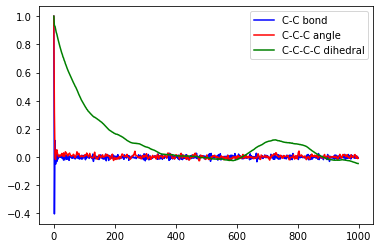

In [33]:
#Lets Calculate the autocorrelation times for bond lengths, bond angles, and torsions:
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else numpy.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return numpy.array(corr)

#time in picoseconds
time=np.linspace(0,20000,traj.n_frames)
print(time)

lags=range(500)
#C1C2bondlength[:,0]
bond_autocor=autocorr1(C1C2bondlength[:,0],lags)
ang_autocor=autocorr1(ang1,lags)
dihe_autocor=autocorr1(np.cos(CCCC_torsion[:,0]),lags)
plt.plot(time[lags],bond_autocor,color='b',label='C-C bond')
plt.plot(time[lags],ang_autocor,color='r',label='C-C-C angle')
plt.plot(time[lags],dihe_autocor,color='g',label='C-C-C-C dihedral')
plt.legend()

**Class Activity: Lets Dig Into force field XML file and make plots of the force field torsion terms**

Documentation of Torsion Term Conventions:

https://ambermd.org/doc12/Amber21.pdf#page=264

http://docs.openmm.org/latest/userguide/application/05_creating_ffs.html#basic-concepts

From Butane.gaff2.xml

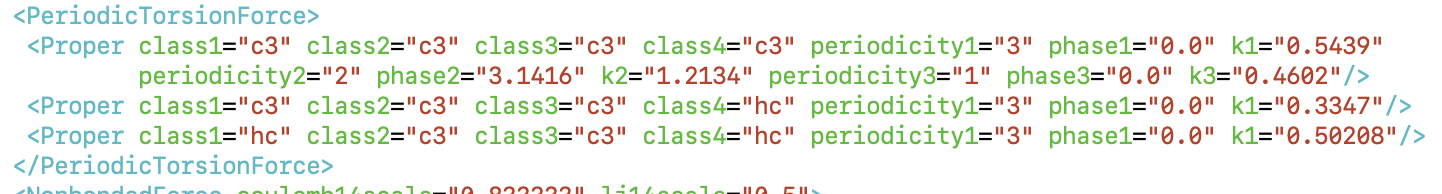

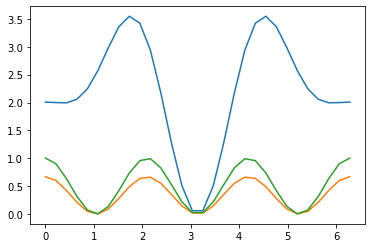

In [34]:
#Plot The Torsion Force Field Terms

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)

##Lets right a function that takes paramters from the xml and writes the force field term

def calc_torsion_energy(angle,k1,period,phase):
     e=k1*(1+np.cos(period*angle-phase))
     return e

def CCCC_torsionE(angle):
 e1=calc_torsion_energy(angle,0.4602,1,0)
 e2=calc_torsion_energy(angle,1.2134,2,3.1416)
 e3=calc_torsion_energy(angle,0.5439,3,0)
 return e1+e2+e3

def CCCH_torsionE(angle):
 e1=calc_torsion_energy(angle,0.3347,3,0)
 return e1

def HCCH_torsionE(angle):
 e1=calc_torsion_energy(angle,0.50208,3,0)
 return e1

CCCC_e=CCCC_torsionE(rad_ang)
CCCH_e=CCCH_torsionE(rad_ang)
HCCH_e=HCCH_torsionE(rad_ang)


plt.plot(rad_ang,CCCC_e)
plt.plot(rad_ang,CCCH_e)
plt.plot(rad_ang,HCCH_e)


In [35]:
##Lets Review all our atoms as we attempt to tabulate all the relevant torsion terms
atoms, bonds = traj.topology.to_dataframe()
atoms

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,C1,C,1,NBU,0,
1,2,H11,H,1,NBU,0,
2,3,H12,H,1,NBU,0,
3,4,H13,H,1,NBU,0,
4,5,C2,C,1,NBU,0,
5,6,H21,H,1,NBU,0,
6,7,H22,H,1,NBU,0,
7,8,C3,C,1,NBU,0,
8,9,H31,H,1,NBU,0,
9,10,H32,H,1,NBU,0,


 <PeriodicTorsionForce>
  <Proper class1="c3" class2="c3" class3="c3" class4="c3" periodicity1="3" phase1="0.0" k1="0.5439" 
          periodicity2="2" phase2="3.1416" k2="1.2134" periodicity3="1" phase3="0.0" k3="0.4602"/>
  <Proper class1="c3" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.3347"/>
  <Proper class1="hc" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.50208"/>

 <PeriodicTorsionForce>
  <Proper class1="c3" class2="c3" class3="c3" class4="c3" periodicity1="3" phase1="0.0" k1="0.5439" 
          periodicity2="2" phase2="3.1416" k2="1.2134" periodicity3="1" phase3="0.0" k3="0.4602"/>
  <Proper class1="c3" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.3347"/>
  <Proper class1="hc" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.50208"/>

In [36]:
#Lets Tally Up All The Torsions Along the Central Carbon
#Atomnames: (H41,H42,H43)-C4-C3(H31,H32)-C2(H21,H22)-C1(H11,H12,H13)
#Atomnumbers: (13,12,11)-10-(8,9)7-4(5,6)-0(1,2,3)

#Central Torsion: 
#C-C-C-C -[10,7,4,0]
#H-C-C-H; [8,7,4,5],[8,7,4,6],[9,7,4,5],[9,7,4,6]  
#H-C-C-H; [6,4,0,1],[6,4,0,2],[6,4,0,3],[5,4,0,1],[5,4,0,2],[5,4,0,3]
#H-C-C-H; [13,10,7,8],[12,10,7,8],[11,10,7,8],[13,10,7,9],[12,10,7,9],[11,10,7,9]
#C-C-C-H -[10,7,4,1],[10,7,4,2],[10,7,4,2],[4,7,10,13],[4,7,10,12],[4,7,10,13]

CCCC_index=[10,7,4,0]
HCCH_indices=[[8,7,4,5],[8,7,4,6],[9,7,4,5],[9,7,4,6],[6,4,0,1],[6,4,0,2],[6,4,0,3],[5,4,0,1],[5,4,0,2],[5,4,0,3],[13,10,7,8],[12,10,7,8],[11,10,7,8],[13,10,7,9],[12,10,7,9],[11,10,7,9]]
CCCH_indices=[10,7,4,1],[10,7,4,2],[10,7,4,2],[4,7,10,13],[4,7,10,12],[4,7,10,13]

HCCH_torsions=md.compute_dihedrals(traj, HCCH_indices)
CCCH_torsions=md.compute_dihedrals(traj, CCCH_indices)
CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])

**Homework Problem #5: Many of These Correlations will be highly Correlated Select Some Torsions that are Correlated, and some that are not, and make scatter plots of their relationships**

For a Torsion Angle Pair that is highly correlated, can you find a relatively constant offset?  Why isn't it always the same?

For a Torsion Angle Pair that are less correlated, how can you interpret their scatter plots?

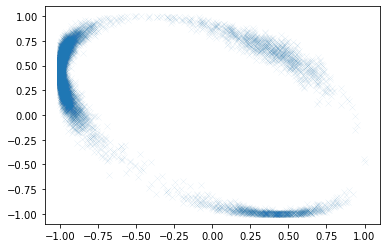

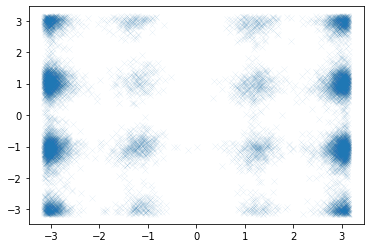

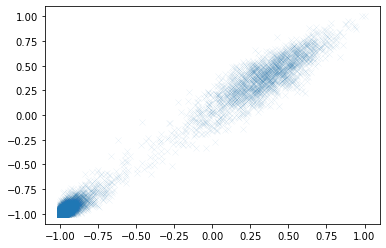

In [37]:
####Homework Problem 5 - Correlations in torsion paramters###
#PLOT SOME TORSIONS THAT YOU EXPECT TO BE HIGHLY CORRELATED - EXPLAIN WHY - EXPLAIN WHAT OU SEE
#Consider CCCC vs. [8,7,4,5]
plt.scatter(np.cos(HCCH_torsions[:,0]),np.cos(HCCH_torsions[:,1]),marker='x',linewidth=0.04)
plt.show()
plt.clf()

#PLOT SOME TORSIONS THAT YOU EXPECT TO BE UNCORRELATED - Explain what you see
#Consider CCCC vs. [12,10,7,9]
plt.scatter(CCCC_torsion,HCCH_torsions[:,14],marker='x',linewidth=0.04)
plt.show()
plt.clf()

plt.scatter(np.cos(CCCC_torsion),np.cos(HCCH_torsions[:,0]),marker='x',linewidth=0.04)
plt.show()

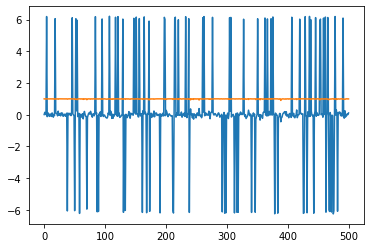

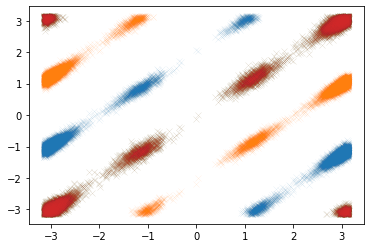

In [38]:
#SELECT TWO TORSIONS THAT YOU EXPECT TO HAVE A SYSTEMATIC OFFSET 
#CALCULATE THEIR OFFSET IN EACH FRAME - EXPLAIN YOUR RESULT
#plt.scatter(CCCC_torsion,HCCH_torsions[:,1],marker='x',linewidth=0.04)
diff=CCCC_torsion[:,0]-HCCH_torsions[:,3]
plt.plot(diff[::20])
plt.plot(np.cos(diff[::20]))
plt.show()
plt.clf()

plt.scatter(HCCH_torsions[:,0],HCCH_torsions[:,1],marker='x',linewidth=0.04)
plt.scatter(HCCH_torsions[:,0],HCCH_torsions[:,2],marker='x',linewidth=0.04)
plt.scatter(HCCH_torsions[:,0],HCCH_torsions[:,3],marker='x',linewidth=0.04)
plt.scatter(HCCH_torsions[:,0],HCCH_torsions[:,3],marker='x',linewidth=0.04)

In [39]:
#COMPUTE THE TOTAL TORSION FORCE FIELD ENERGY PER FRAME
CCCC_E=CCCC_torsionE(CCCC_torsion[:,0])
HCCH_E=HCCH_torsionE(HCCH_torsions)
CCCH_E=CCCH_torsionE(CCCH_torsions)
#plt.scatter(CCCH_torsions[:,0],CCCH_E[:,0])
HCCH_totalE=np.sum(HCCH_E,axis=1)
CCCH_totalE=np.sum(CCCH_E,axis=1)
Total_TorsionE=CCCC_E+HCCH_totalE+CCCH_totalE

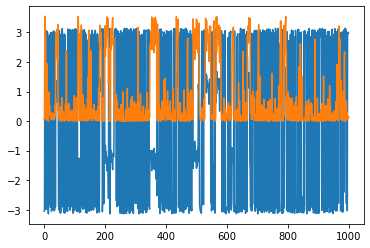

In [40]:
#Compare the time course of CCCC torsion with its energy 
#Interpret what you are seeing in terms of conformations and energies

CCCC_E=CCCC_torsionE(CCCC_torsion[:,0])
plt.plot(CCCC_torsion[:,0][::10])
plt.plot(CCCC_E[::10])

#CCCH_e=CCCH_torsion(rad_ang)
#HCCH_e=HCCH_torsion(rad_ang)

Plot The Total Torsion Energy As a Function of the C-C-C-C Dihedral Angle - Compare your plot Energetic Torsion Barriers from Cramer.  How Can you explain the Difference?

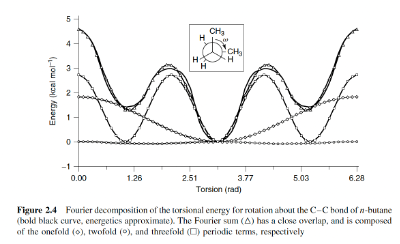

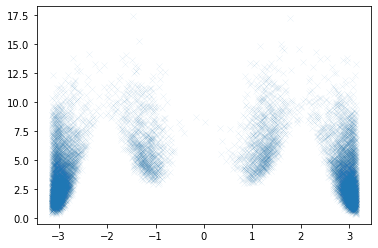

In [41]:
#Solution
plt.scatter(CCCC_torsion[:,0],Total_TorsionE,marker='x',linewidth=.04)

***Homework Problem #6: Lets modify the C-C-C-C Torsion Potential to change the dihedral distribution***


Lets try to lower the dihedral barriers for torsion angles of 1 radian (~60 degrees)
This means we need to to come up with a torsion potential, potentially by using multiple terms with different phases, to equalize the free energy of each C-C-C-C torsion basin (increasing the free energy at $\pi$ and lowering 
free energy at $\pi$/3

Once you've come up with torsion terms you're happy with, you'll need to make a copy of the butane.gaff2.xml, add in the additional torsion terms you have come up with, and run a new simulation.  Then plot the C-C-C-C dihedral histogram or PMF, and compare it to the simulation with original force field.

It would be great if you came up with some kind of fitting routine to determine the coefficients of torsions, perhaps by targeting a gaussian, or you can try to arrive at by hand using something like this:

https://www.desmos.com/calculator/ea1qhzjnuf

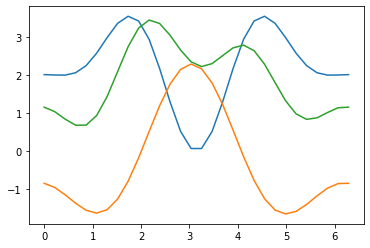

In [42]:
###SOLUTION#####

def CCCC_cor(angle):
 e1=calc_torsion_energy(angle,-2.16,1,-0.4)
 e2=calc_torsion_energy(angle,0.8,1,-1)
 e3=calc_torsion_energy(angle,1.04,2,-0.2)
 return e1+e2+e3

CCCC_corE=CCCC_cor(rad_ang)
CCCC_e=CCCC_torsionE(rad_ang)


plt.plot(rad_ang,CCCC_e)
plt.plot(rad_ang,CCCC_corE)
plt.plot(rad_ang,CCCC_corE+CCCC_e)


def calc_torsion_energy(angle,k1,period,phase):
     e=k1*(1+np.cos(period*angle-phase))
     return e

***Homework Problem #7: Attempt to run a new MD Simulation with your modified torsion potential***

Once you have made a torsion correction you like make a new force field file 'butane.gaff2.cor1.xml'.

Run a new simulation with this force field and compare the dihedral distributions 

In [43]:
###SOLUTION###
#ONCE YOU HAVE FOUND SOME TORSION CORRECTIONS RUN A NEW SIMULATION 
#Make a new force field file 'butane.gaff2.cor1.xml'
datadir='/Users/paulrobustelli/Desktop/CHEM.101.6/butane/data/'
workDir='/Users/paulrobustelli/Desktop/CHEM.101.6/butane/outdir/'
initial_pdb='/Users/paulrobustelli/Desktop/CHEM.101.6/butane/data/butane.pdb'
force_field='/Users/paulrobustelli/Desktop/CHEM.101.6/butane/data/butane.gaff2.cor1.xml'

if not os.path.exists(workDir):
    os.makedirs(workDir)
    
print(initial_pdb)
print(force_field )

pdb = mm.app.PDBFile(initial_pdb)
forcefield = mm.app.ForceField(force_field)


system = forcefield.createSystem(pdb.topology, nonbondedMethod=mm.app.NoCutoff, constraints=mm.app.HBonds)
integrator = mm.LangevinIntegrator(298.15*openmm.unit.kelvin, 5.0/unit.picoseconds, 2.0*unit.femtoseconds)
integrator.setConstraintTolerance(1e-5)

platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

integrator = mm.LangevinIntegrator(298.15*unit.kelvin, 5.0/unit.picoseconds, 2.0*unit.femtoseconds)
integrator.setConstraintTolerance(1e-5)

print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 100, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*unit.kelvin)
simulation.step(2500)

/Users/paulrobustelli/Desktop/CHEM.101.6/butane/data/butane.pdb
/Users/paulrobustelli/Desktop/CHEM.101.6/butane/data/butane.gaff2.cor1.xml
Minimizing...
Potential energy before minimization is 8.054040750343281 kJ/mol
Potential energy after minimization is 7.551809632962446 kJ/mol
Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
100,48.88433707732321,147.0693511939703
200,34.32315145562329,219.2667666437843
300,31.01408969661984,187.65902204542775
400,50.36890597963665,306.6511418026125
500,56.862515838448076,283.40033770387714
600,61.376863836716105,279.89823950122
700,62.556934113239976,256.71660705619814
800,38.70079123021235,343.9324942968274
900,47.26775815220752,239.00638717265267
1000,33.24480905170587,455.2372851089829
1100,48.345972368853744,349.48079447610587
1200,43.2694668720344,241.0744310638164
1300,38.4394955877779,213.4307592292886
1400,44.172961058669344,303.2704179939322
1500,50.43626046034112,295.5293962562863
1600,54.021798733820404,321.362676

In [44]:
import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.DCDReporter(workDir+'butane_sim.cor1.dcd', 100))

# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(1000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
250000,500.0000000016593,29.443642970447165,301.8010518837816,0
500000,999.9999999901769,29.900945455312367,253.74783938764085,1.73e+04
750000,1499.9999999783536,23.4931047759433,498.81742027638757,1.73e+04
1000000,1999.9999999665301,51.25483043139008,290.3135845274965,1.73e+04
Done!
Time required for simulation: 10.013863801956177 seconds


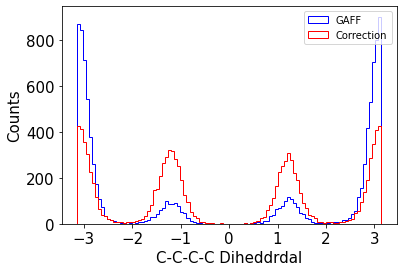

In [45]:
#print(workDir+'butane_sim.dcd')
#simulation.reporters.append(app.DCDReporter(workDir+'butane_sim.dcd', 100))
traj2 = md.load(workDir+'butane_sim.cor1.dcd', top=initial_pdb)
traj2
#traj.superpose(ref)
CCCC_index=[10,7,4,0]
CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])
CCCC_torsion2=md.compute_dihedrals(traj2, [CCCC_index])
plt.hist(CCCC_torsion,bins=100,histtype='step',color='b',label='GAFF')
plt.hist(CCCC_torsion2,bins=100,histtype='step',color='r',label='Correction')

plt.legend(loc='upper right')
plt.xlabel('C-C-C-C Diheddrdal', size=15)
plt.xticks(size=15)
plt.ylabel('Counts', size=15)
plt.yticks(size=15)
plt.show()

In [46]:
t = ngl.MDTrajTrajectory(traj2)
w = ngl.NGLWidget(t)
w

NGLWidget(max_frame=9999)

Gauche Transitions: 69 Average Residence Time (ps): 6265.217391304348


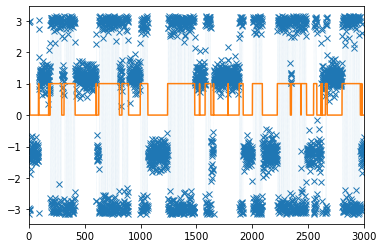

In [51]:
time_series=CCCC_torsion2[:,0]
state_assign=np.zeros(len(time_series))
frame_set=np.where((CCCC_torsion2[:,0]<-2) | (CCCC_torsion2[:,0]>2))
state_assign[frame_set]=1
plt.plot(time_series,marker='x',linewidth=.01)
plt.plot(state_assign)
plt.xlim(0,3000)

gauche=0
n=0
res_time=[]

for i in range(1,len(state_assign)):
    if state_assign[i]==1:
     if gauche==0:
      gauche=1
     n+=1
    if state_assign[i]==0:
     gauche=0   
     if state_assign[i-1]!=0:
      res_time.append(n)
      n=0
#Traj=1000000 ps / 10000 frames
#100ps/frame
print("Gauche Transitions:",len(res_time),"Average Residence Time (ps):",np.average(res_time)*100)

**Homework Problem #8:  Calculate LJ and Coulumb Forcefield Potentials for 3 types of atom pairs**

**Challenge Problem:  Atempt to calculate all LJ interactions for a frame and all frames.  What does lj14scale mean?**


**Challenge Problem #2:  Attempt to calculate all Coulumb interactions for a frame and all frames**

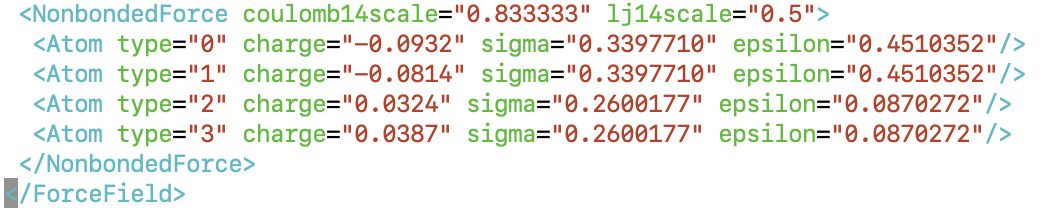

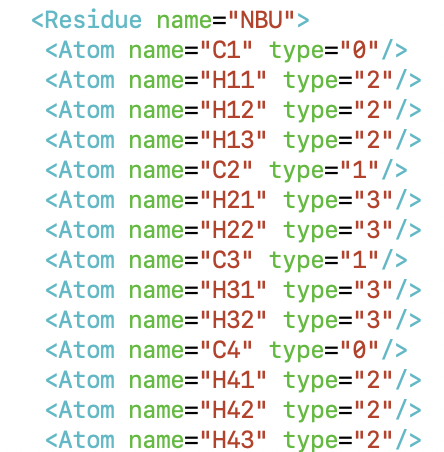

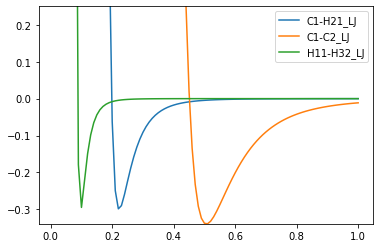

In [47]:
#Calculate LJ and Couloumb Potentionals Here
#Adapted Jiaqi's Notebook

sig1 = 0.3397710
ep1 = 0.4510352
sig2 = 0.2600177
ep2 = 0.0870272
c1 = -0.0932
c2 = -0.0814
c3 = 0.0324
c4 = 0.0387 
# Type 1: C1-H21 (0-3), type2 = C1-C2 (0-1), type3 = H11-H32 (2-3)
r = np.linspace(0.01,1.0,100)
def LJ(sig,ep,r):
    A = 4*sig*(ep**12)
    B = 4*sig*(ep**6)
    return A/(r**12)-B/(r**6)

def combine_sig(sig1,sig2):
    return 0.5*sig1 + 0.5*sig2

def combine_ep(ep1,ep2):
    return (ep1*ep2)**0.5

C1H21_LJ = LJ(combine_sig(sig1,sig2),combine_ep(ep1,ep2),r)
C1C2_LJ = LJ(combine_sig(sig1,sig1),combine_ep(ep1,ep1),r)
H11H32_LJ = LJ(combine_sig(sig2,sig1),combine_ep(ep2,ep2),r)

plt.plot(r,C1H21_LJ, label = 'C1-H21_LJ')
plt.plot(r,C1C2_LJ, label = 'C1-C2_LJ')
plt.plot(r,H11H32_LJ, label = 'H11-H32_LJ')
plt.ylim(min(C1C2_LJ),.25)
plt.legend()
plt.show()

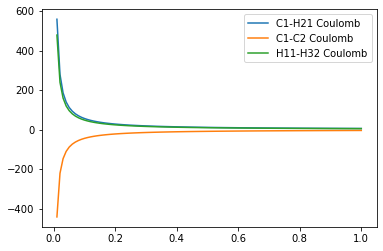

<Figure size 432x288 with 0 Axes>

In [48]:
# Coulumbic potential
# Atom paird: 0-1, 1-2, 2-3
#Adapted Jiaqi's Notebook

def coulumb(q1,q2,r,ep):
    return (332*q1*q2)/(ep*r)

co1 = coulumb(c1,c2,r,combine_ep(ep1,ep1))
co2 = coulumb(c2,c3,r,combine_ep(ep1,ep2))
co3 = coulumb(c3,c4,r,combine_ep(ep2,ep2))

plt.plot(r,co1, label = 'C1-H21 Coulomb')
plt.plot(r,co2, label = 'C1-C2 Coulomb')
plt.plot(r,co3, label = 'H11-H32 Coulomb')
plt.legend()
plt.show()
plt.clf()

***Having fun with small molecule simulations?  Why not simulate a new molecule that you think might be interesting***

You can install a conda package that lets you generate a molecular structure and force field from a SMILES string:

conda install --yes -c conda-forge openmmforcefields
conda install -c conda-forge openff-toolkit    

And you can find the documentation to generate a structure and force field for a compound here
https://github.com/openmm/openmmforcefields

You can draw a structure here and convert it to a SMILES string and download and sdf file to build an openMM system here: 

http://www.cheminfo.org/Chemistry/Cheminformatics/FormatConverter/index.html

